# 1. 데이터베이스에서 데이터 로드 (처음 한번만 실행)

In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
from datetime import date, timedelta, time 
import json

with open("./db_config.json", "r") as f:
    config = json.load(f)
    
DB_USER = config["DB_USER"]
DB_PASSWORD = config["DB_PASSWORD"]
DB_HOST = config["DB_HOST"]
DB_NAME = config["DB_NAME"]
DB_PORT = config["DB_PORT"]

# SQLAlchemy 엔진 생성
engine_url = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

try:
    engine = create_engine(engine_url)
    print("MySQL 데이터베이스에 성공적으로 연결되었습니다.")
except Exception as e:
    print(f"데이터베이스 연결 오류: {e}")
    exit()

# --- 데이터베이스에서 데이터 로드하는 함수 ---
def load_table_to_df(table_name, engine):
    """지정된 테이블에서 모든 데이터를 Pandas DataFrame으로 로드합니다."""
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, engine)
        print(f"'{table_name}' 테이블 로드 완료. {len(df)} 행.")
        # 날짜/시간 컬럼 타입 변환 (필요시)
        if 'game_date' in df.columns:
            df['game_date'] = pd.to_datetime(df['game_date'])
        if 'accident_date' in df.columns:
            df['accident_date'] = pd.to_datetime(df['accident_date'])
        if 'weather_date' in df.columns:
            df['weather_date'] = pd.to_datetime(df['weather_date'])
        # start_time, end_time, weather_time은 문자열로 로드될 수 있으므로, 필요시 time 객체로 변환
        return df
    except Exception as e:
        print(f"'{table_name}' 테이블 로드 중 오류 발생: {e}")
        return pd.DataFrame() # 오류 발생 시 빈 DataFrame 반환

# --- 데이터 로드 ---
stadium_df = load_table_to_df('stadium', engine)
sports_game_df = load_table_to_df('sports_game', engine)
traffic_accident_df = load_table_to_df('traffic_accident', engine)
weather_df = load_table_to_df('weather', engine)

# 데이터베이스 연결 종료
if 'engine' in locals() and engine:
    engine.dispose()
    print("\n데이터베이스 연결이 종료되었습니다.")

MySQL 데이터베이스에 성공적으로 연결되었습니다.
'stadium' 테이블 로드 완료. 60 행.
'sports_game' 테이블 로드 완료. 3631 행.
'traffic_accident' 테이블 로드 완료. 34032 행.
'weather' 테이블 로드 완료. 450811 행.

데이터베이스 연결이 종료되었습니다.


# 2. 데이터셋을 구성할 지역구 입력

In [17]:
# 사용자로부터 지역명을 입력받아 데이터 셋 구성
START_DATE = pd.to_datetime("2023-01-01") # 분석 시작일
END_DATE = pd.to_datetime("2024-12-31")   # 분석 종료일
stadium_region = stadium_df['region'].unique().tolist()
TARGET_REGION = None
while True:
    input_region = input("데이터셋을 구성할 지역구를 입력해주세요:")
    for r in stadium_region:
        r_split = r.split(' ')[1]
        if input_region in r_split:
            TARGET_REGION = r
            break
    if TARGET_REGION:
        break
    else:
        print(f"입력하신 {input_region}은 정보가 없습니다. 다시 입력해주세요.")
print(f"선택한 지역: {TARGET_REGION}")        
date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
base_df = pd.DataFrame({'date': date_range})
base_df['region_code'] = TARGET_REGION

선택한 지역: 울산 남구


# 3. 입력한 지역구를 기반으로 데이터 셋 구성

In [18]:
# TARGET_REGION에 따른 데이터 셋 구성

# 스타디움 정보 가져오기
if not stadium_df.empty:
    stadiums_in_target_region = stadium_df[stadium_df['region'] == TARGET_REGION]
    stadium_codes_in_region = stadiums_in_target_region['stadium_code'].unique().tolist()
    print(f"\n{TARGET_REGION} 내 경기장 코드: {stadium_codes_in_region}")
else:
    stadium_codes_in_region = []
    print(f"\n{TARGET_REGION} 내 경기장 정보 없음 또는 stadium 테이블 로드 실패.")

# 스포츠경기 정보 가져오기
if not sports_game_df.empty and stadium_codes_in_region:
    games_in_region_df = sports_game_df[sports_game_df['stadium_code'].isin(stadium_codes_in_region)]
    games_in_region_df = games_in_region_df.rename(columns={'game_date': 'date'})
    #print(games_in_region_df)
    if not games_in_region_df.empty:
        games_in_region_df["match_type"] = (
            games_in_region_df["match_type"]
                .replace({"페넌트레이스": "정규시즌",
                        "순위결정전": "정규시즌",
                        "순위결정정": "정규시즌",   # 오타까지 함께 처리
                        '조별리그' : "정규시즌",
                        "0": "정규시즌"})
                # ➋ 라운드 표기(1R ~ 33R 등) → 정규시즌
                .str.replace(r"^\d+R$", "정규시즌", regex=True)
        )
        games_in_region_df["match_type"] = (
            games_in_region_df["match_type"]
                .replace({'와일드카드':"포스트시즌",
                        '준플레이오프':"포스트시즌", 
                        '플레이오프':"포스트시즌", 
                        '한국시리즈':"포스트시즌",
                        '파이널 라운드A':"포스트시즌",
                        '파이널 라운드B':"포스트시즌",
                        '챔피언결정전':"포스트시즌", 
                        '준결승':"포스트시즌", 
                        '결승':"포스트시즌"})
        )
        game_summary_df = games_in_region_df.groupby('date').agg(
            game_count=('stadium_code', 'count'),
            sports_types_list=('sports_type', lambda x: list(set(x))),
            is_post_season_list=('match_type', lambda x: 1 if any('포스트시즌' in str(mt).lower() for mt in x) else 0)
        ).reset_index()
        
        game_summary_df['sports_types'] = game_summary_df['sports_types_list'].apply(lambda x: ','.join(sorted(x)) if x else '없음')
        game_summary_df['is_post_season'] = game_summary_df['is_post_season_list']
        game_summary_df = game_summary_df[['date', 'game_count', 'sports_types', 'is_post_season']]
        base_df = pd.merge(base_df, game_summary_df, on='date', how='left')
    else:
        print(f"{TARGET_REGION} 내 해당 기간 경기 정보 없음.")
        base_df['game_count'] = 0
        base_df['sports_types'] = '없음'
        base_df['is_post_season'] = 0
else:
    print("sports_game_df 로드 실패 또는 대상 지역 내 경기장 없음.")
    base_df['game_count'] = 0
    base_df['sports_types'] = '없음'
    base_df['is_post_season'] = 0

base_df['game_count'] = base_df['game_count'].fillna(0).astype(int)
base_df['sports_types'] = base_df['sports_types'].fillna('없음')
base_df['is_post_season'] = base_df['is_post_season'].fillna(0).astype(int)

# 5. 교통 사고 데이터 가져오기
if not traffic_accident_df.empty:
    accidents_in_region_df = traffic_accident_df[traffic_accident_df['region'] == TARGET_REGION]
    accidents_in_region_df = accidents_in_region_df.rename(columns={'accident_date': 'date'})
    if not accidents_in_region_df.empty:
        accident_summary_df = accidents_in_region_df.groupby('date').agg(
            accident_count_sum=('accident_count', 'sum')
        ).reset_index()
        accident_summary_df = accident_summary_df.rename(columns={'accident_count_sum': 'accident_count'})
        
        base_df = pd.merge(base_df, accident_summary_df, on='date', how='left')
    else:
        print(f"{TARGET_REGION} 내 해당 기간 교통사고 정보 없음.")
        base_df['accident_count'] = 0
else:
    print("traffic_accident_df 로드 실패.")
    base_df['accident_count'] = 0
    
base_df['accident_count'] = base_df['accident_count'].fillna(0).astype(int)

# 날씨 데이터 가져오기
if not weather_df.empty:
    weather_region_df = weather_df[weather_df['region'] == "수원"]
    weather_region_df = weather_region_df.rename(columns={'weather_date': 'date'})

    if not weather_region_df.empty:
        # 날씨 데이터는 하루에 여러 번 기록될 수 있으므로, 일별 집계 필요
        weather_summary_df = weather_region_df.groupby('date').agg(
            temperature=('temperature', 'mean'),
            precipitation=('precipitation', 'sum'),
            snow_depth=('snow_depth', 'sum'),
            avg_cloud_amount=('cloud_amount', 'mean') # 대표 날씨 상태 추론용
        ).reset_index()

        def get_weather_condition(row):
            if (pd.isna(row['precipitation']) or pd.isna(row['snow_depth'])) and pd.isna(row['avg_cloud_amount']):
                return '정보없음' # 데이터가 없는 경우
            if row['precipitation'] > 0 or pd.isna(row['snow_depth']) > 0:
                return '비/눈'
            elif pd.notna(row['avg_cloud_amount']):
                if row['avg_cloud_amount'] >= 7: # (0-10 기준)
                    return '흐림'
                elif row['avg_cloud_amount'] >= 3:
                    return '구름조금' # 또는 '약간흐림' 등
                else:
                    return '맑음'
            return '정보없음' # 강수량 없고 구름 정보도 없는 경우
            
        weather_summary_df['weather_condition'] = weather_summary_df.apply(get_weather_condition, axis=1)
        weather_summary_df = weather_summary_df[['date', 'temperature', 'precipitation', 'snow_depth', 'weather_condition']]
        
        base_df = pd.merge(base_df, weather_summary_df, on='date', how='left')
    else:
        print(f"{TARGET_REGION} 내 해당 기간 날씨 정보 없음.")
        base_df['temperature'] = pd.NA
        base_df['precipitation'] = pd.NA
        base_df['snow_depth'] = pd.NA
        base_df['weather_condition'] = '정보없음'
else:
    print("weather_df 로드 실패.")
    base_df['temperature'] = pd.NA
    base_df['precipitation'] = pd.NA
    base_df['snow_depth'] = pd.NA
    base_df['weather_condition'] = '정보없음'

# 공휴일 및 주말 데이터 가져오기
weekday_map_kr = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
base_df['weekday'] = base_df['date'].dt.dayofweek.map(weekday_map_kr)

try:
    import holidays
    # base_df['date']에서 연도를 뽑아와서 unique 값으로 추출
    kr_holidays = holidays.KR(years=base_df['date'].dt.year.unique().tolist()) 
    is_statutory_holiday = base_df['date'].apply(lambda d: d in kr_holidays)
    is_saturday = (base_df['weekday'] == '토')
    is_sunday = (base_df['weekday'] == '일')
    # 3. 세 가지 조건을 OR 연산자로 결합하여 is_holiday 컬럼 생성
    # (하나라도 True이면 True -> 1, 모두 False이면 False -> 0)
    base_df['is_holiday'] = (is_statutory_holiday | is_saturday | is_sunday).astype(int)
except ImportError:
    print("`holidays` 라이브러리가 설치되지 않았습니다. `pip install holidays`로 설치해주세요. 'is_holiday'는 0으로 처리됩니다.")
    base_df['is_holiday'] = 0
except Exception as e:
    print(f"공휴일 정보 처리 중 오류: {e}. 'is_holiday'는 0으로 처리됩니다.")
    base_df['is_holiday'] = 0
    
# 최종 데이터 셋 구성
final_df = base_df[[
    'date', 'region_code', 'accident_count', 'game_count', 'sports_types',
    'is_post_season', 'temperature', 'precipitation', 'snow_depth', 'weather_condition',
    'is_holiday', 'weekday'
]].copy() # SettingWithCopyWarning 방지를 위해 .copy() 사용

final_df['date'] = final_df['date'].dt.strftime('%Y-%m-%d')
final_df['temperature'] = pd.to_numeric(final_df['temperature'], errors='coerce').round(1)
final_df['precipitation'] = pd.to_numeric(final_df['precipitation'], errors='coerce').round(1)



울산 남구 내 경기장 코드: ['US01', 'US02', 'US03']


# 4. 최종 데이터 셋 csv 파일로 저장 및 DataFrame 출력 

In [19]:
from datetime import datetime

final_df.to_csv(f"./results/2nd-dataset_{TARGET_REGION}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index=False)
print("\n--- Final Dataset ---")
final_df


--- Final Dataset ---


,date,region_code,accident_count,game_count,sports_types,is_post_season,temperature,precipitation,snow_depth,weather_condition,is_holiday,weekday
0,2023-01-01,울산 남구,0,0,없음,0,-2.0,0.0,0.0,맑음,1,일
1,2023-01-02,울산 남구,5,0,없음,0,-5.2,0.0,0.0,맑음,0,월
2,2023-01-03,울산 남구,3,0,없음,0,-6.2,0.0,0.0,맑음,0,화
3,2023-01-04,울산 남구,2,0,없음,0,-3.5,0.0,0.0,맑음,0,수
4,2023-01-05,울산 남구,2,0,없음,0,-3.6,0.0,0.0,구름조금,0,목
...,...,...,...,...,...,...,...,...,...,...,...,...
726,2024-12-27,울산 남구,1,0,없음,0,-2.7,0.0,0.6,맑음,0,금
727,2024-12-28,울산 남구,1,0,없음,0,-3.1,0.0,0.9,맑음,1,토
728,2024-12-29,울산 남구,0,0,없음,0,0.5,0.0,0.0,구름조금,1,일
729,2024-12-30,울산 남구,6,0,없음,0,5.0,0.0,0.0,구름조금,0,월


# 5. EDA 출력

--- 1. Initial Data Inspection ---
Shape of the dataframe: (731, 12)

First 5 rows:
         date region_code  accident_count  game_count sport_types  \
0  2023-01-01      부산 동래구               1           0          없음   
1  2023-01-02      부산 동래구               1           0          없음   
2  2023-01-03      부산 동래구               1           0          없음   
3  2023-01-04      부산 동래구               3           0          없음   
4  2023-01-05      부산 동래구               1           0          없음   

   has_playoff  temperature  precipitation  snow_depth weather_condition  \
0            0         -2.0            0.0         0.0                맑음   
1            0         -5.2            0.0         0.0                맑음   
2            0         -6.2            0.0         0.0                맑음   
3            0         -3.5            0.0         0.0                맑음   
4            0         -3.6            0.0         0.0              구름조금   

   is_holiday weekday  
0           1       

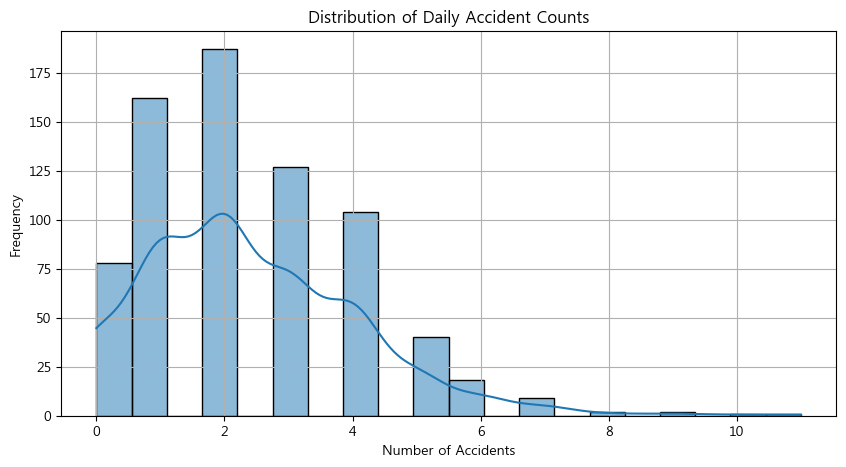

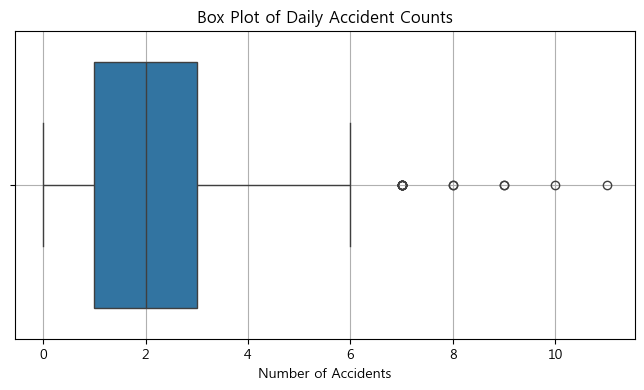

Accident count statistics:
count    731.000000
mean       2.406293
std        1.689748
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       11.000000
Name: accident_count, dtype: float64


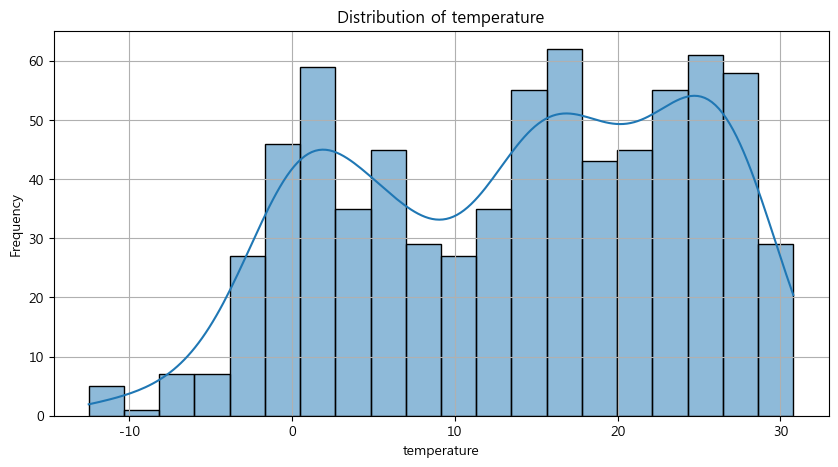

temperature statistics:
count    731.000000
mean      13.761560
std       10.350757
min      -12.500000
25%        4.600000
50%       15.000000
75%       23.200000
max       30.800000
Name: temperature, dtype: float64


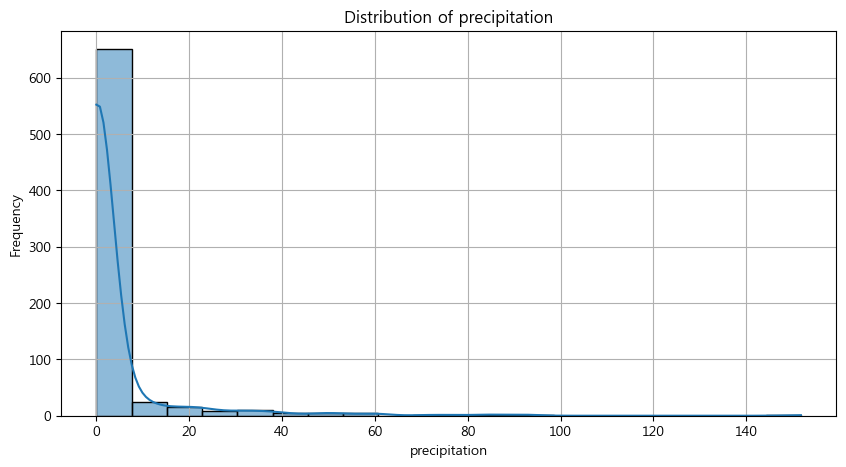

precipitation statistics:
count    731.000000
mean       3.813406
std       12.705175
min        0.000000
25%        0.000000
50%        0.000000
75%        0.400000
max      151.800000
Name: precipitation, dtype: float64


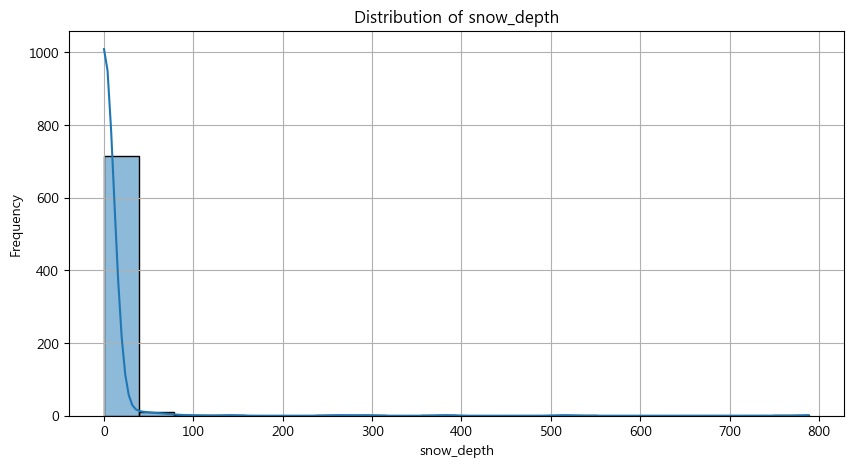

snow_depth statistics:
count    731.000000
mean       4.436662
std       41.144813
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      788.400000
Name: snow_depth, dtype: float64


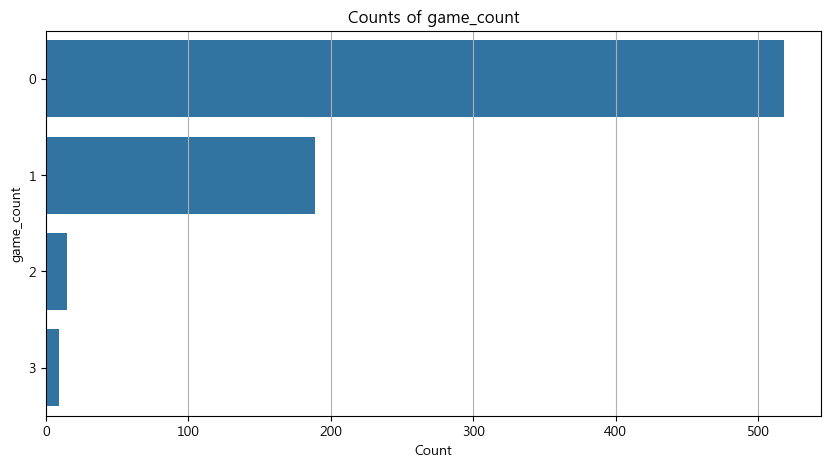


Value counts for game_count:
game_count
0    70.861833
1    25.854993
2     2.051984
3     1.231190
Name: proportion, dtype: float64 %


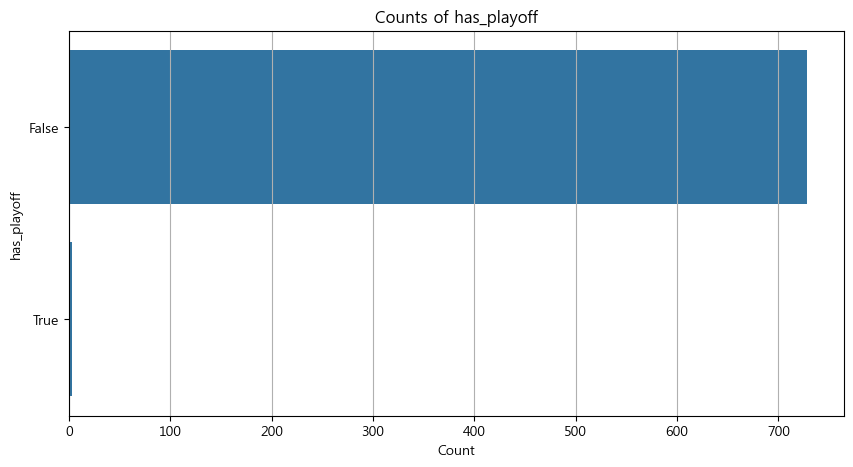


Value counts for has_playoff:
has_playoff
False    99.589603
True      0.410397
Name: proportion, dtype: float64 %


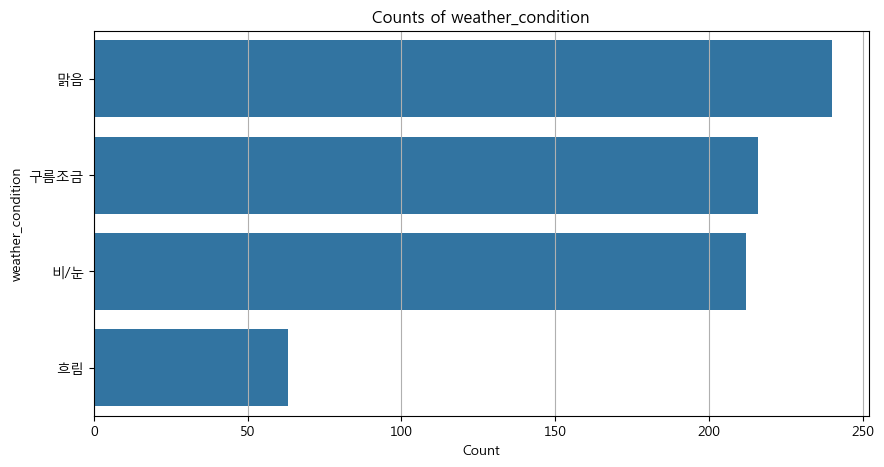


Value counts for weather_condition:
weather_condition
맑음      32.831737
구름조금    29.548564
비/눈     29.001368
흐림       8.618331
Name: proportion, dtype: float64 %


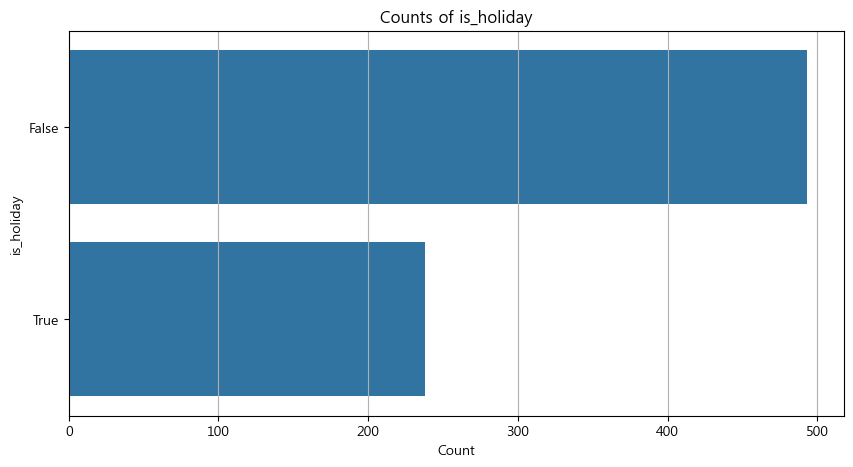


Value counts for is_holiday:
is_holiday
False    67.44186
True     32.55814
Name: proportion, dtype: float64 %


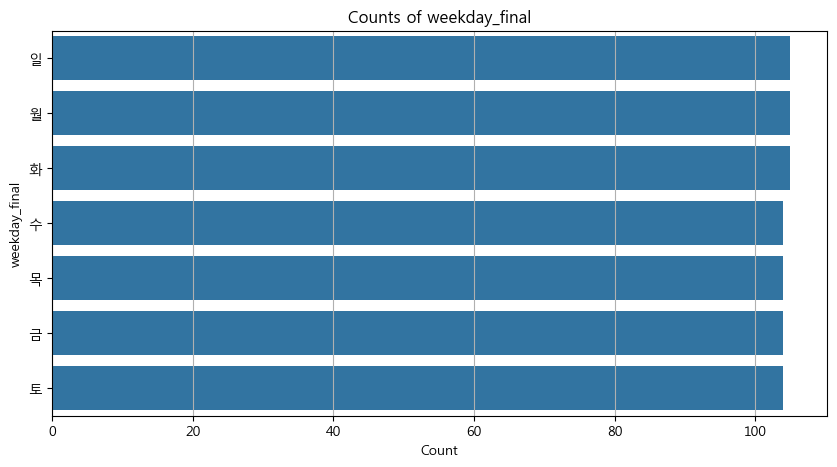


Value counts for weekday_final:
weekday_final
일    14.363885
월    14.363885
화    14.363885
수    14.227086
목    14.227086
금    14.227086
토    14.227086
Name: proportion, dtype: float64 %


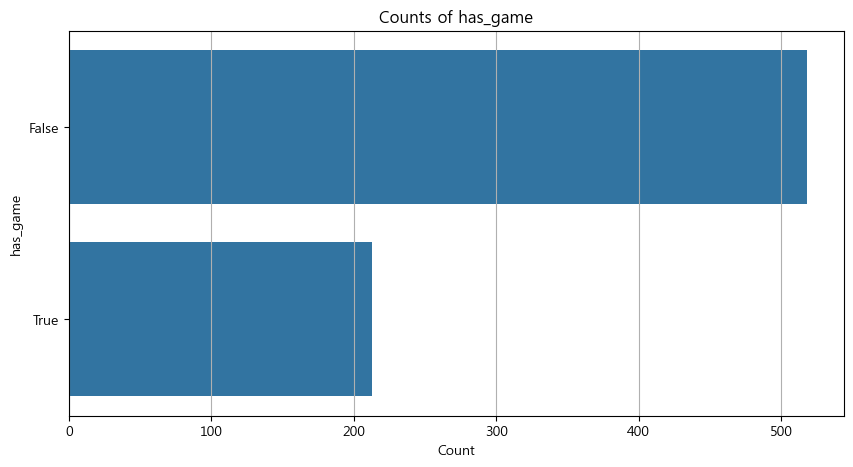


Value counts for has_game:
has_game
False    70.861833
True     29.138167
Name: proportion, dtype: float64 %


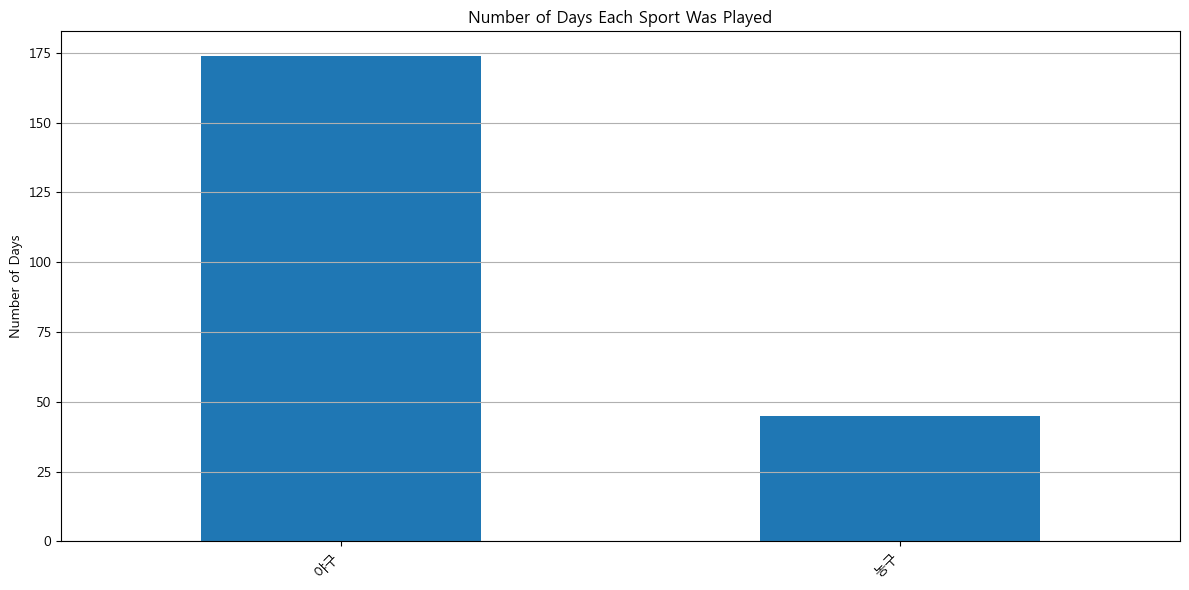


--- 5. Bivariate and Multivariate Analysis ---


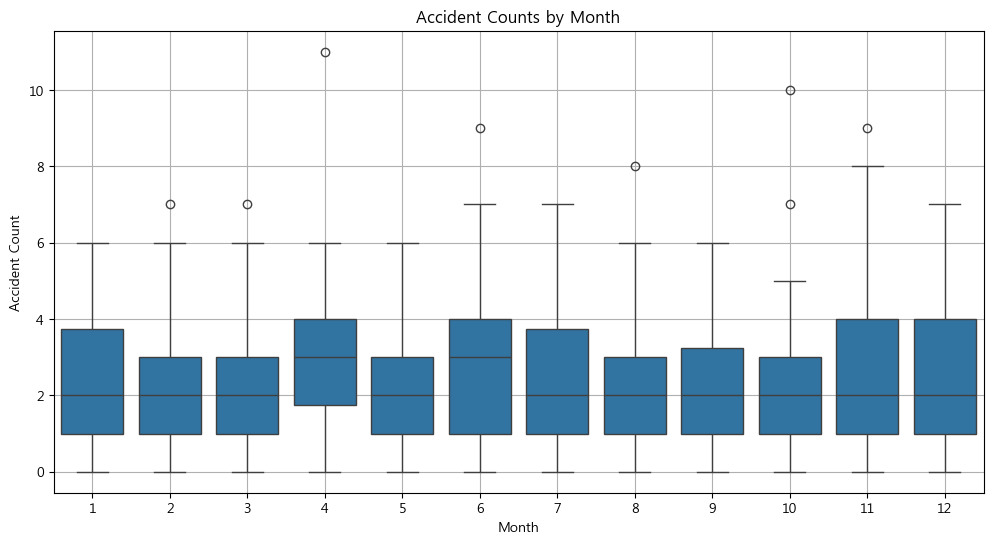

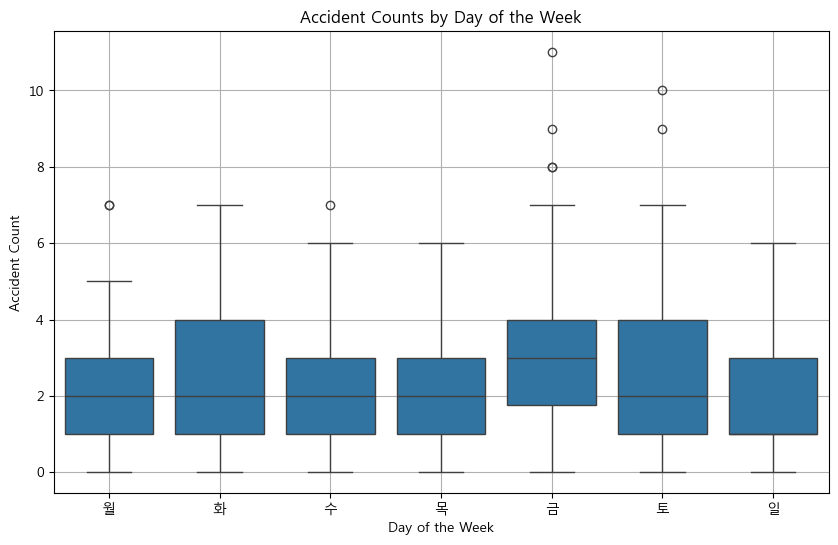

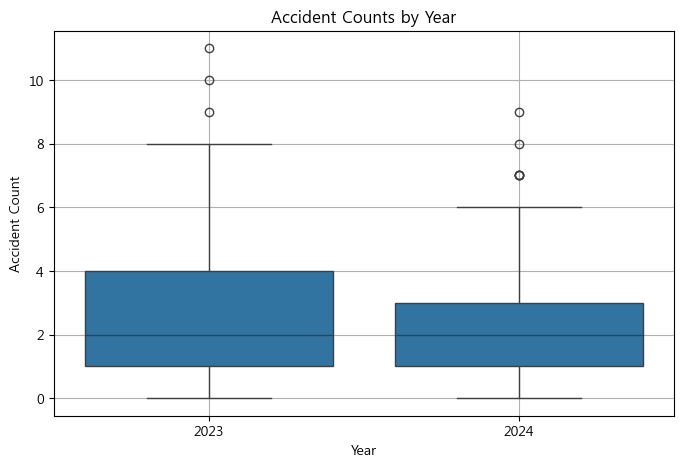

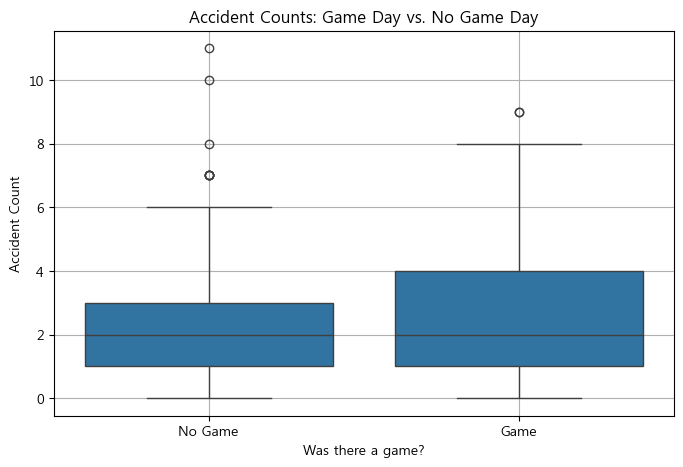

          count      mean       std  min  25%  50%  75%   max
has_game                                                     
False     518.0  2.357143  1.649646  0.0  1.0  2.0  3.0  11.0
True      213.0  2.525822  1.781864  0.0  1.0  2.0  4.0   9.0


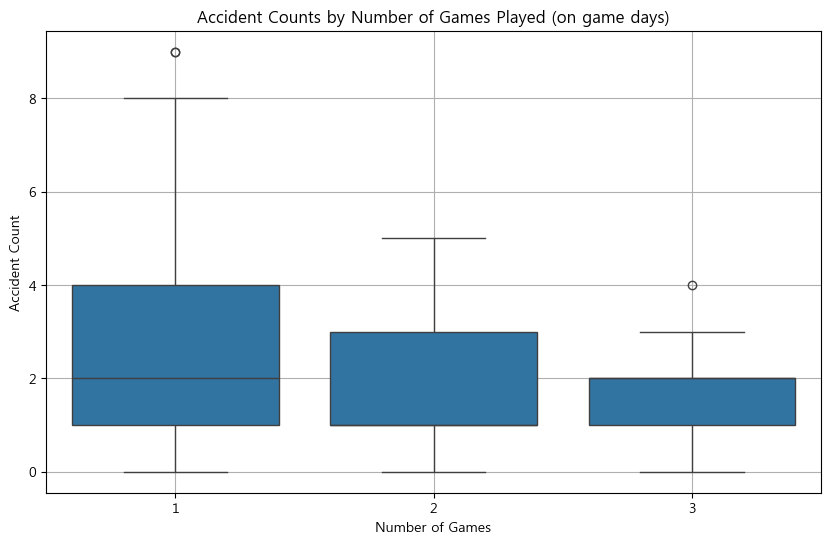

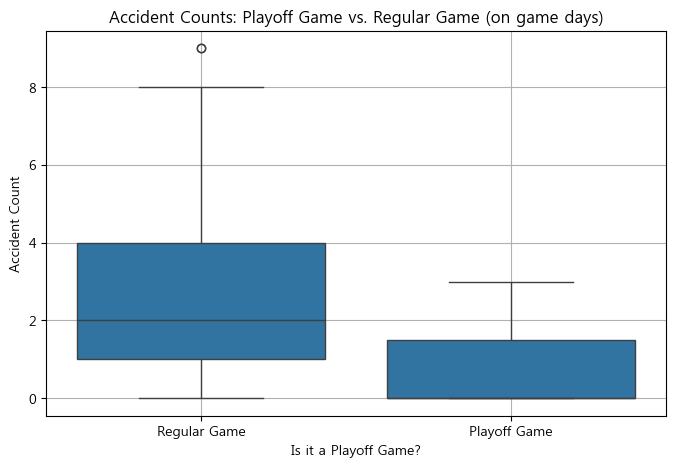

             count      mean       std  min  25%  50%  75%  max
has_playoff                                                    
False        210.0  2.547619  1.777079  0.0  1.0  2.0  4.0  9.0
True           3.0  1.000000  1.732051  0.0  0.0  0.0  1.5  3.0


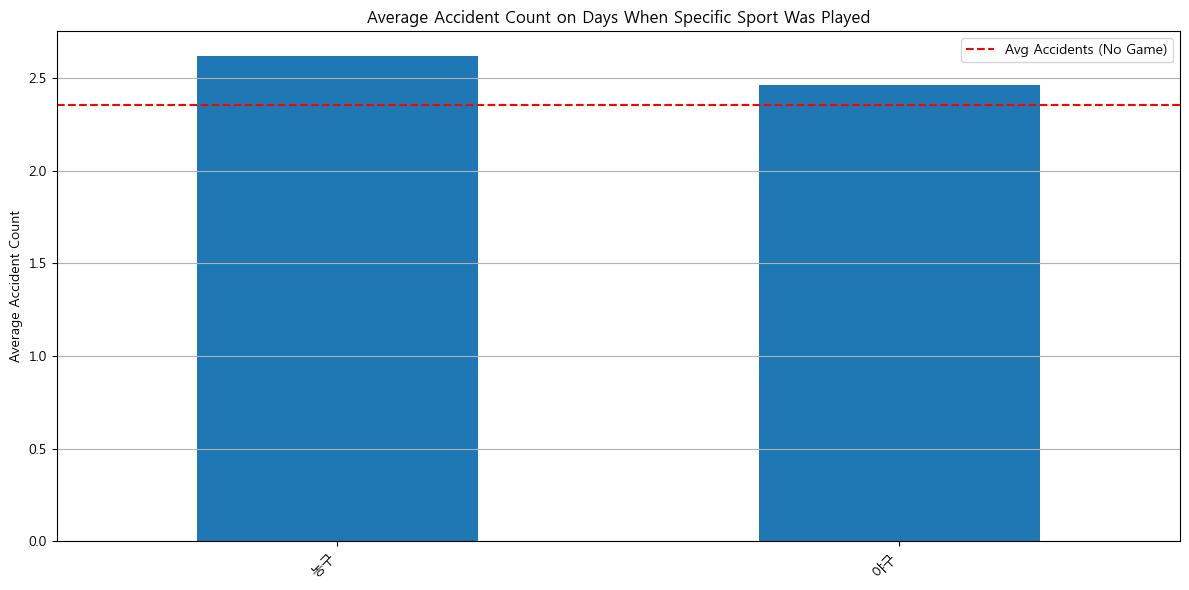

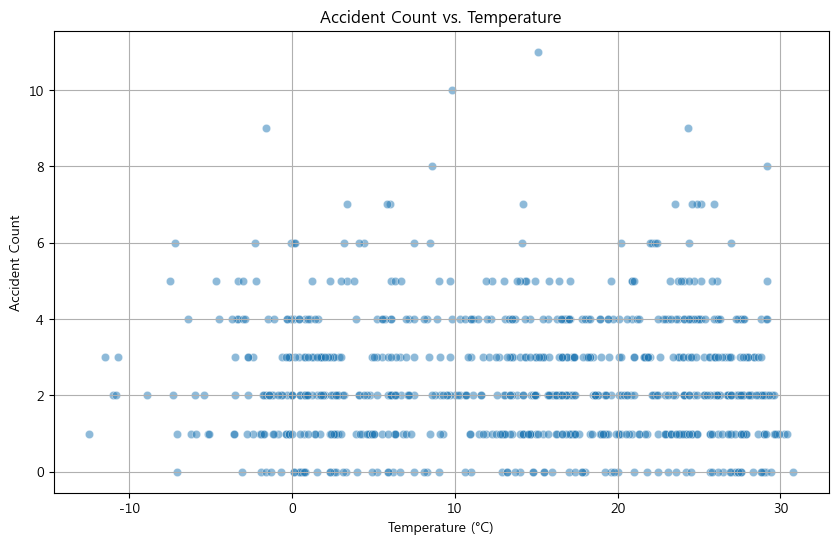

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


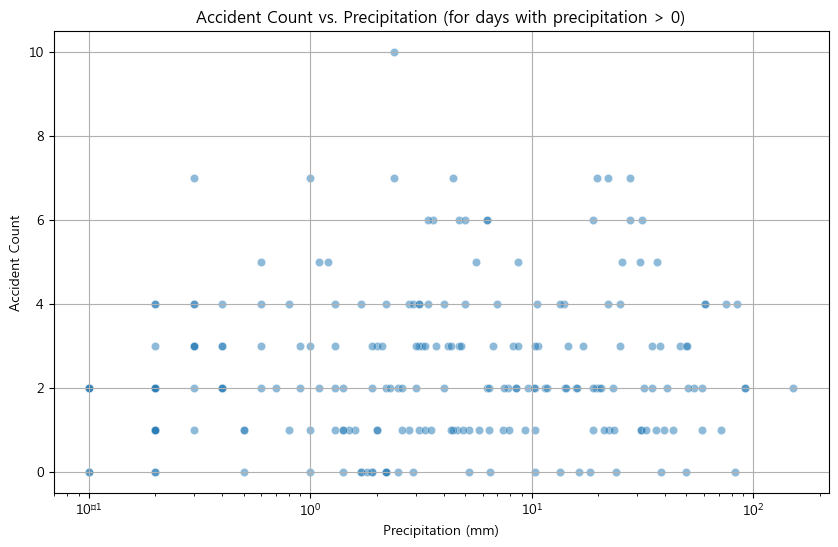

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


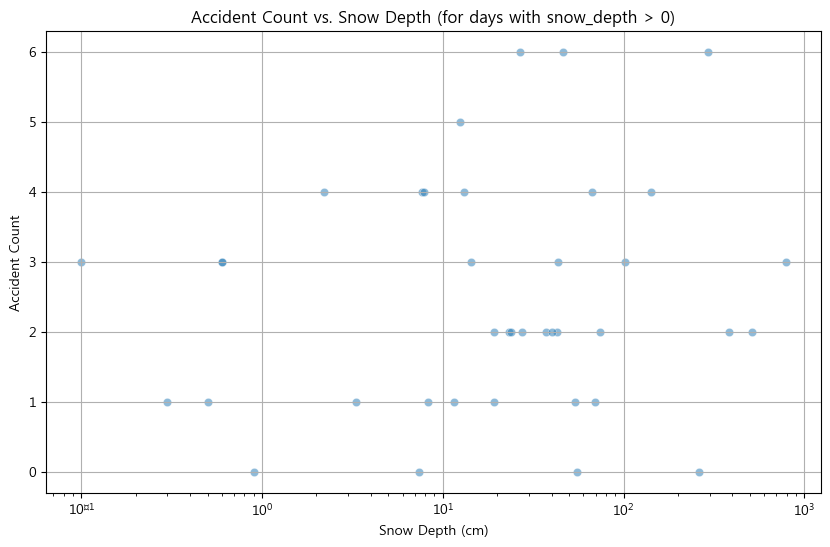

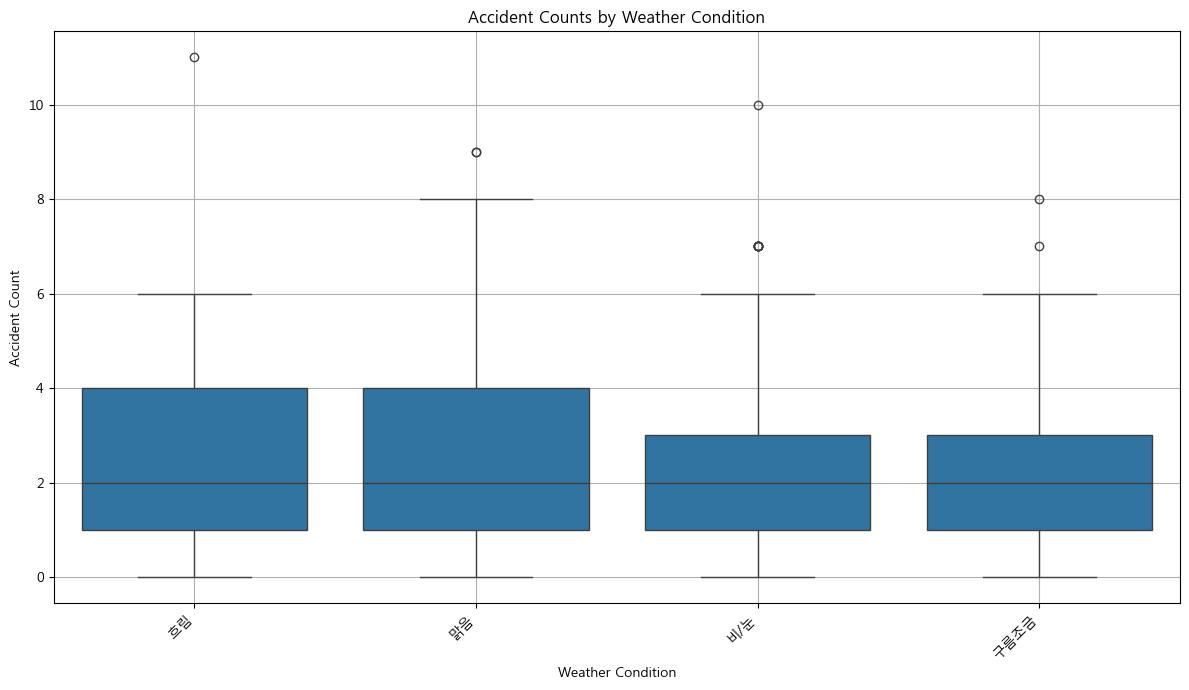

                   count      mean       std  min  25%  50%  75%   max
weather_condition                                                     
구름조금               216.0  2.259259  1.490250  0.0  1.0  2.0  3.0   8.0
맑음                 240.0  2.450000  1.671068  0.0  1.0  2.0  4.0   9.0
비/눈                212.0  2.443396  1.832204  0.0  1.0  2.0  3.0  10.0
흐림                  63.0  2.619048  1.895909  0.0  1.0  2.0  4.0  11.0


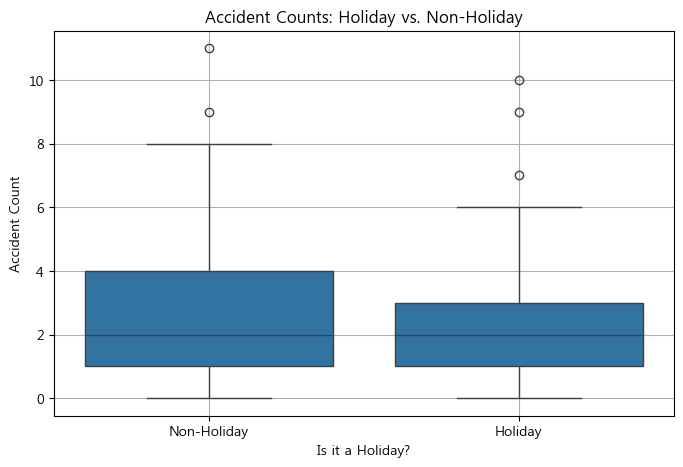

            count      mean       std  min  25%  50%  75%   max
is_holiday                                                     
False       493.0  2.549696  1.672368  0.0  1.0  2.0  4.0  11.0
True        238.0  2.109244  1.690329  0.0  1.0  2.0  3.0  10.0


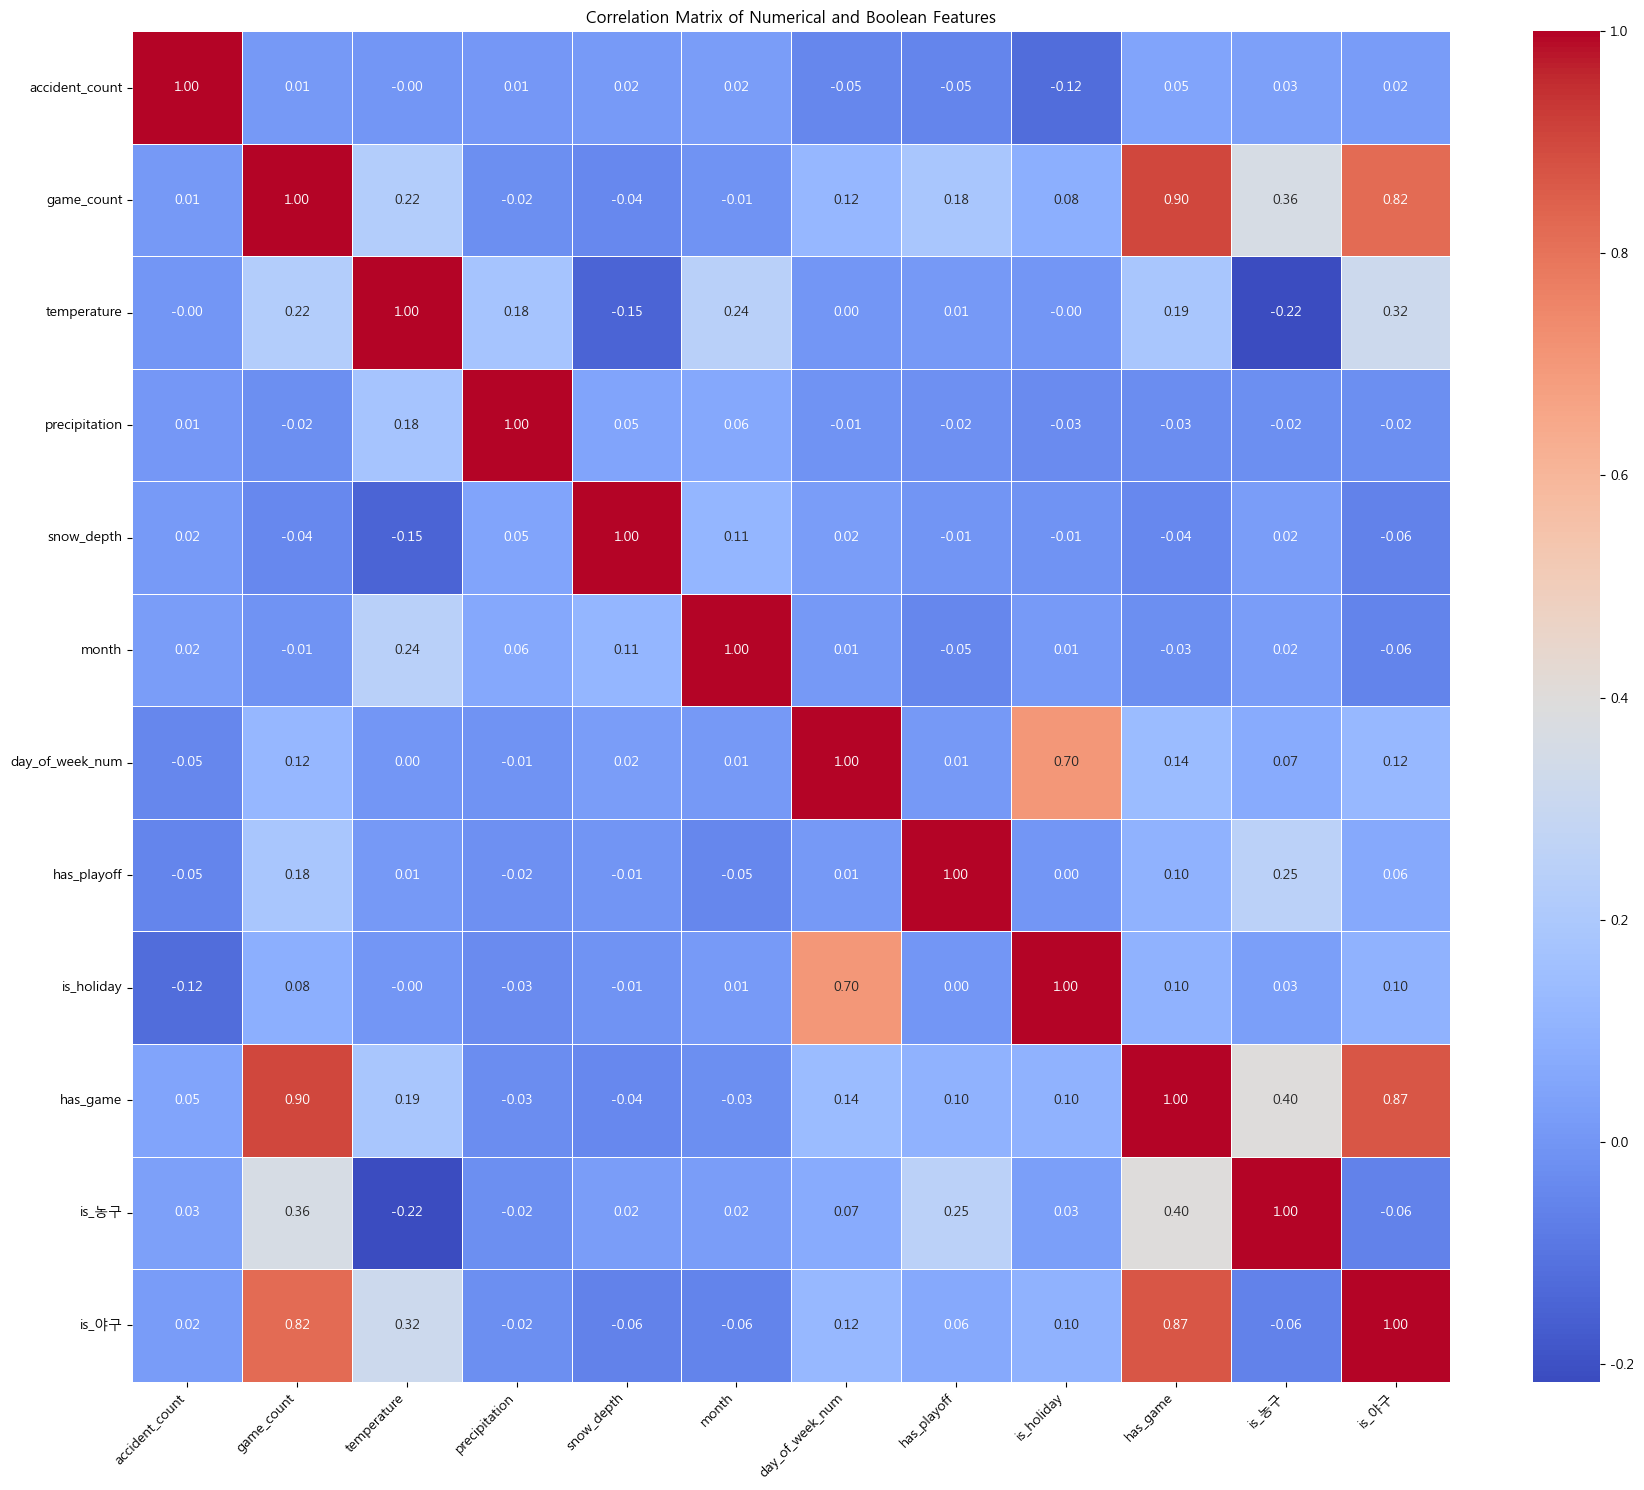


--- 6. Time Series Analysis of Accident Counts ---


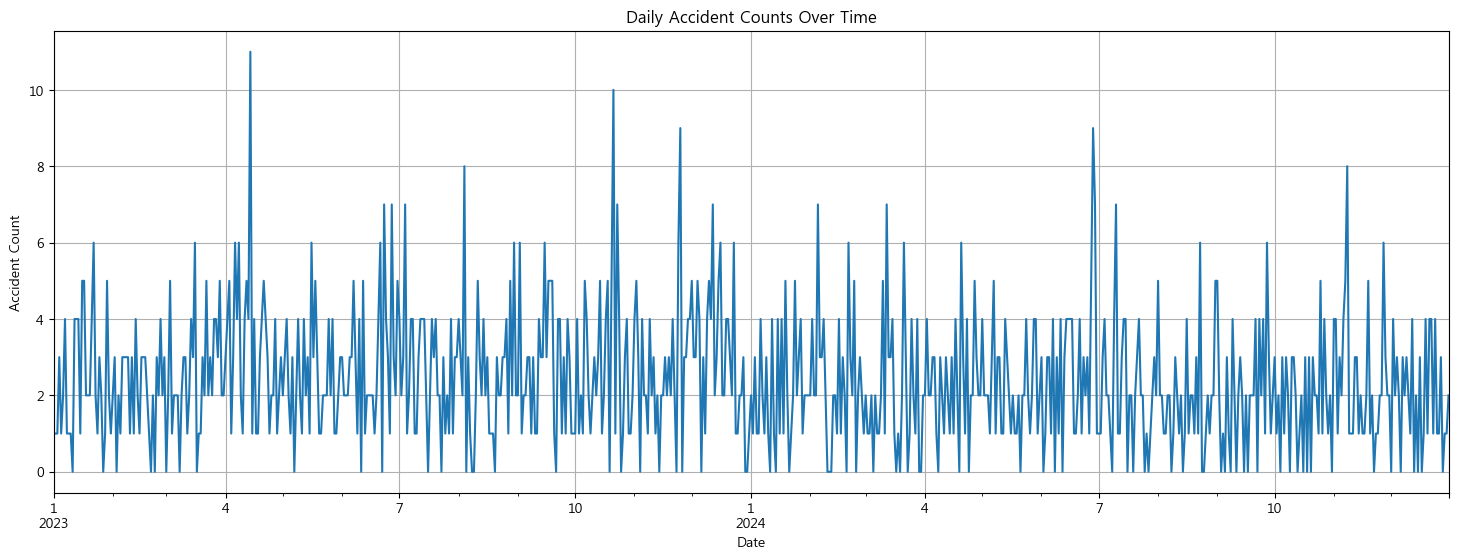

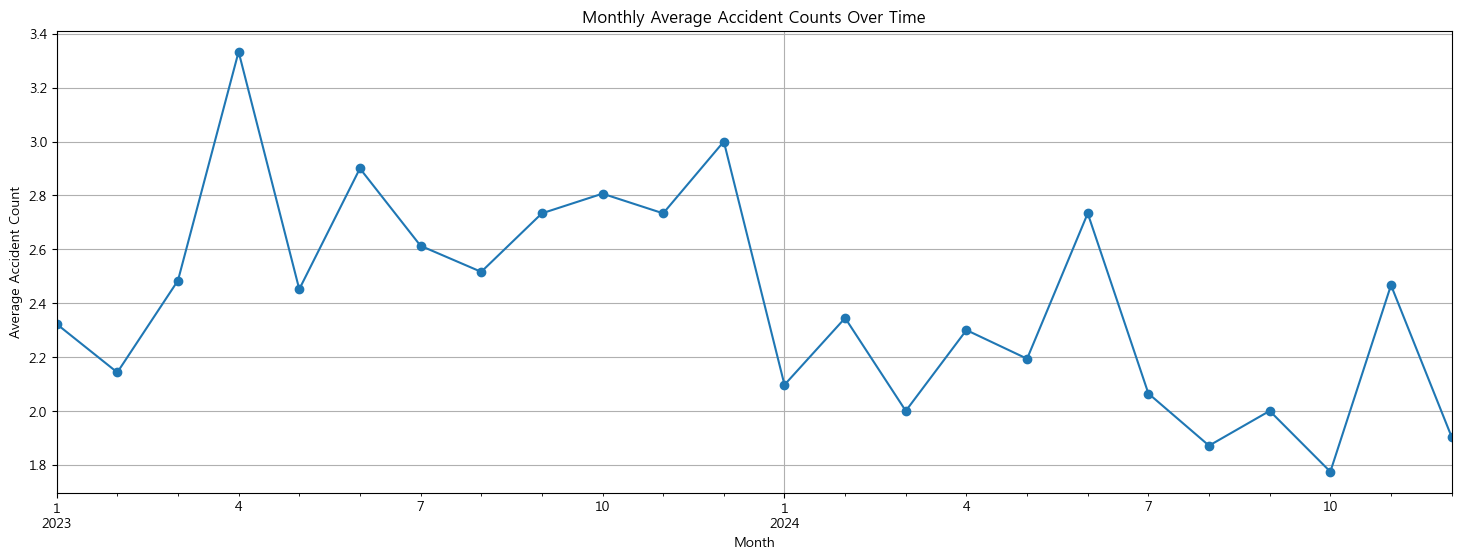


--- 7. Combined Effects (Examples) ---


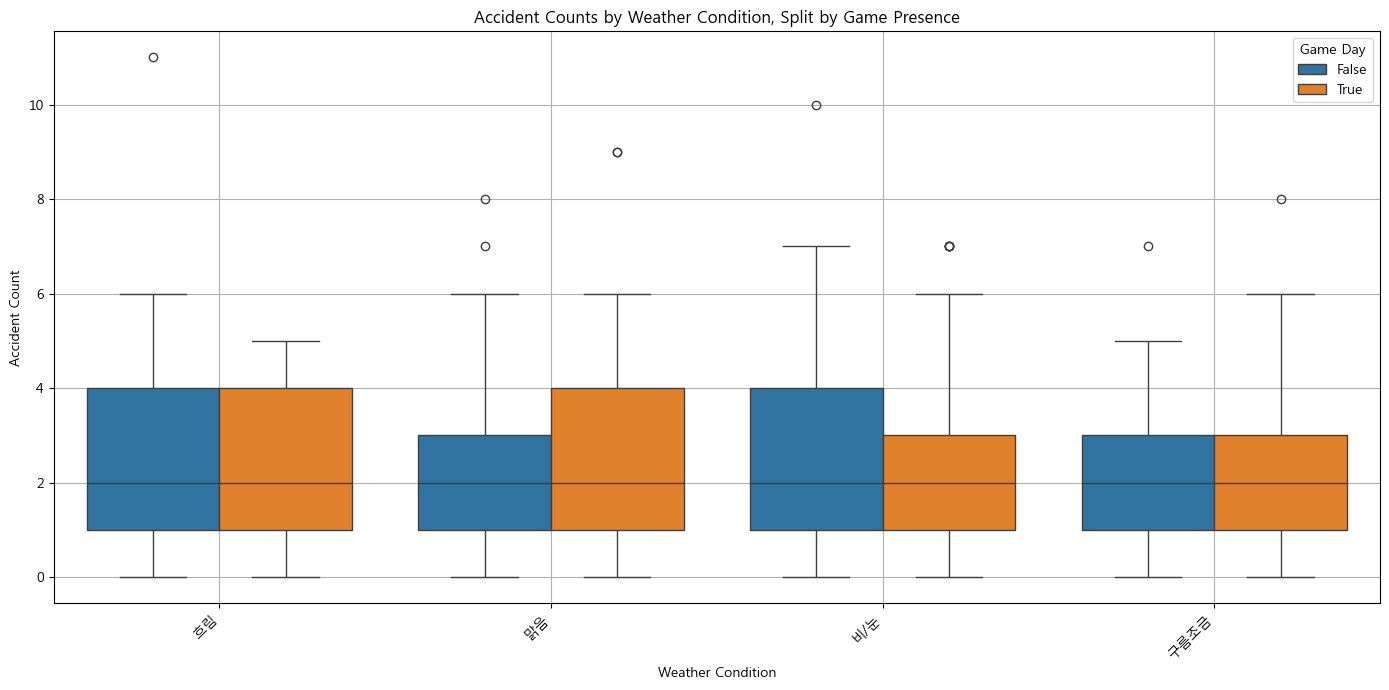

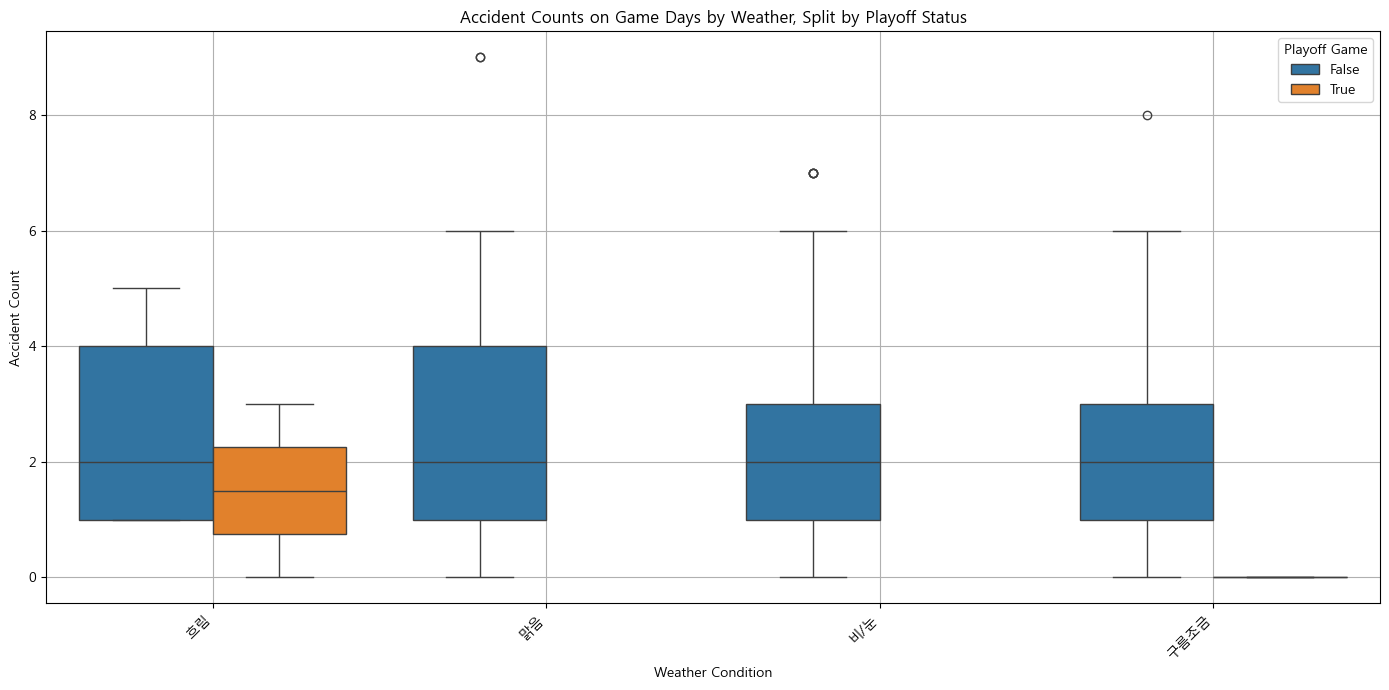

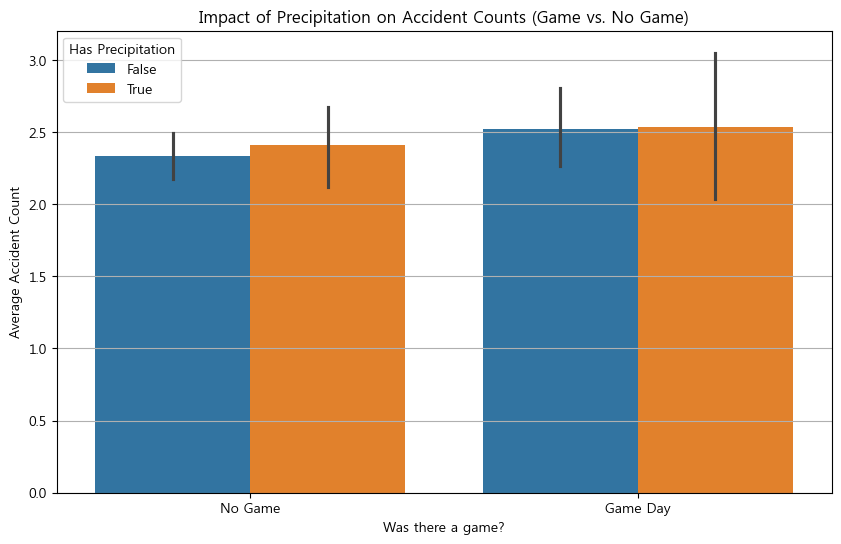

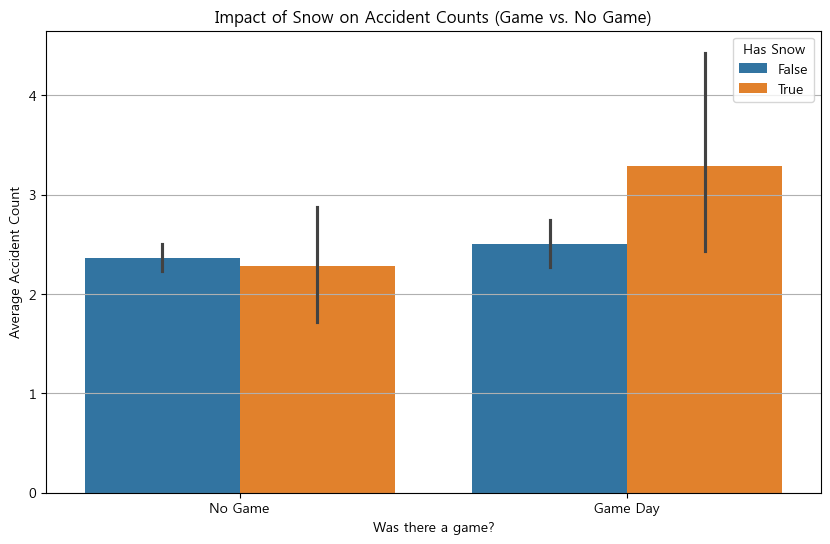


--- 8. Focus on Extreme Accident Days ---

Days with accident_count >= 4.0 (Top 10%):

          date  accident_count  game_count sport_types  has_playoff  \
103 2023-04-14              11           0          없음        False   
293 2023-10-21              10           0          없음        False   
328 2023-11-25               9           1          농구        False   
544 2024-06-28               9           1          야구        False   
215 2023-08-04               8           1          야구        False   
..         ...             ...         ...         ...          ...   
237 2023-08-26               4           1          야구        False   
225 2023-08-14               4           0          없음        False   
212 2023-08-01               4           1          야구        False   
208 2023-07-28               4           0          없음        False   
723 2024-12-24               4           0          없음        False   

     temperature  precipitation  snow_depth weather_conditi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Korean font for matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # To display minus sign correctly

df = final_df.copy()

print("--- 1. Initial Data Inspection ---")
print("Shape of the dataframe:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and non-null counts:")
df.info()
print("\nSummary statistics for numerical columns:")
print(df.describe())
print("\nSummary statistics for object columns:")
print(df.describe(include='object'))
print("\nMissing values per column:")
print(df.isnull().sum())

print("\n--- 2. Data Cleaning and Preprocessing ---")
# Convert 'date' to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Convert boolean-like columns to actual booleans for clarity if needed (0/1 is fine for most analyses)
df['is_post_season'] = df['is_post_season'].astype(bool)
df['is_holiday'] = df['is_holiday'].astype(bool)

# Create a column 'has_game' for easier filtering
df['has_game'] = df['game_count'] > 0

# Check consistency: region_code
print("\nUnique values in 'region_code':", df['region_code'].unique())
# If 'region_code' is constant, we might drop it for modeling, but keep for EDA context.

# Clean sports_types: "없음" means no sport, otherwise it's a list
# For analysis, we can create dummy variables for common sports
all_sports = set()
for sports_list in df['sports_types'].unique():
    if sports_list != "없음":
        for sport in sports_list.split(','):
            all_sports.add(sport.strip()) # .strip() to remove potential leading/trailing spaces

print("\nIdentified unique sport types:", sorted(list(all_sports)))

# Create boolean columns for each identified sport
for sport in sorted(list(all_sports)):
    df[f'is_{sport}'] = df['sports_types'].apply(lambda x: sport in x)

print("\nDataFrame with new sport boolean columns (first 5 rows):")
print(df.head())


print("\n--- 3. Feature Engineering (Time-based features) ---")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week_num'] = df['date'].dt.dayofweek # Monday=0, Sunday=6
df['day_name'] = df['date'].dt.day_name()
# Verify 'weekday' column consistency (optional, if 'weekday' is already reliable)
# df['day_name_korean'] = df['date'].dt.strftime('%a') # Mon, Tue... in Korean locale (if set)

# Map day_of_week_num to Korean day names for consistency with provided 'weekday'
day_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
df['derived_weekday'] = df['day_of_week_num'].map(day_map)

# Check if derived_weekday matches the provided weekday column
if 'weekday' in df.columns:
    mismatch_count = (df['derived_weekday'] != df['weekday']).sum()
    print(f"\nNumber of mismatches between derived weekday and provided weekday: {mismatch_count}")
    if mismatch_count > 0:
        print("Consider using the derived weekday or thoroughly checking the provided one.")
        # For now, we'll prioritize the derived one for consistency if there's a discrepancy
        # Or, trust the provided one if it's confirmed correct. Let's use the derived one.
        df['weekday_final'] = df['derived_weekday']
    else:
        df['weekday_final'] = df['weekday'] # or derived_weekday, they are the same
else:
    df['weekday_final'] = df['derived_weekday']


print("\n--- 4. Univariate Analysis ---")

# 4.1 Distribution of Accident Count
plt.figure(figsize=(10, 5))
sns.histplot(df['accident_count'], kde=True, bins=20)
plt.title('Distribution of Daily Accident Counts')
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['accident_count'])
plt.title('Box Plot of Daily Accident Counts')
plt.xlabel('Number of Accidents')
plt.grid(True)
plt.show()
print(f"Accident count statistics:\n{df['accident_count'].describe()}")

# 4.2 Distribution of Numerical Weather Features
weather_cols = ['temperature', 'precipitation', 'snow_depth']
for col in weather_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    print(f"{col} statistics:\n{df[col].describe()}")

# 4.3 Counts of Categorical Features
categorical_cols = ['game_count', 'is_post_season', 'weather_condition', 'is_holiday', 'weekday_final', 'has_game']
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[col], order = df[col].value_counts().index) # y for better label readability
    plt.title(f'Counts of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.grid(axis='x')
    plt.show()
    print(f"\nValue counts for {col}:\n{df[col].value_counts(normalize=True)*100} %")

# 4.4 Sport Types Distribution (among days with games)
sport_counts = {}
for sport in sorted(list(all_sports)):
    sport_counts[sport] = df[f'is_{sport}'].sum()

plt.figure(figsize=(12, 6))
pd.Series(sport_counts).sort_values(ascending=False).plot(kind='bar')
plt.title('Number of Days Each Sport Was Played')
plt.ylabel('Number of Days')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


print("\n--- 5. Bivariate and Multivariate Analysis ---")

# 5.1 Accident Count vs. Time Features
# Monthly
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='accident_count', data=df)
plt.title('Accident Counts by Month')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.grid(True)
plt.show()

# Day of the week
weekday_order = ['월', '화', '수', '목', '금', '토', '일']
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday_final', y='accident_count', data=df, order=weekday_order)
plt.title('Accident Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Accident Count')
plt.grid(True)
plt.show()

# Year (if multiple years exist)
if df['year'].nunique() > 1:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='year', y='accident_count', data=df)
    plt.title('Accident Counts by Year')
    plt.xlabel('Year')
    plt.ylabel('Accident Count')
    plt.grid(True)
    plt.show()

# 5.2 Accident Count vs. Game-Related Features
# Has Game?
plt.figure(figsize=(8, 5))
sns.boxplot(x='has_game', y='accident_count', data=df)
plt.title('Accident Counts: Game Day vs. No Game Day')
plt.xlabel('Was there a game?')
plt.ylabel('Accident Count')
plt.xticks([0, 1], ['No Game', 'Game'])
plt.grid(True)
plt.show()
print(df.groupby('has_game')['accident_count'].describe())

# Game Count (for days with games)
plt.figure(figsize=(10, 6))
sns.boxplot(x='game_count', y='accident_count', data=df[df['has_game']]) # Only for days with games
plt.title('Accident Counts by Number of Games Played (on game days)')
plt.xlabel('Number of Games')
plt.ylabel('Accident Count')
plt.grid(True)
plt.show()

# Has Playoff? (for days with games)
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_post_season', y='accident_count', data=df[df['has_game']]) # Only for days with games
plt.title('Accident Counts: Playoff Game vs. Regular Game (on game days)')
plt.xlabel('Is it a Playoff Game?')
plt.ylabel('Accident Count')
plt.xticks([0, 1], ['Regular Game', 'Playoff Game'])
plt.grid(True)
plt.show()
print(df[df['has_game']].groupby('is_post_season')['accident_count'].describe())

# Specific sports
sports_accidents_mean = {}
for sport in sorted(list(all_sports)):
    sports_accidents_mean[sport] = df[df[f'is_{sport}']]['accident_count'].mean()

plt.figure(figsize=(12, 6))
pd.Series(sports_accidents_mean).sort_values(ascending=False).plot(kind='bar')
plt.title('Average Accident Count on Days When Specific Sport Was Played')
plt.ylabel('Average Accident Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.axhline(df[df['has_game']==False]['accident_count'].mean(), color='red', linestyle='--', label='Avg Accidents (No Game)')
plt.legend()
plt.tight_layout()
plt.show()

# 5.3 Accident Count vs. Weather Features
# Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='accident_count', data=df, alpha=0.5)
plt.title('Accident Count vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Accident Count')
plt.grid(True)
plt.show()

# Precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='precipitation', y='accident_count', data=df[df['precipitation'] > 0], alpha=0.5)
plt.title('Accident Count vs. Precipitation (for days with precipitation > 0)')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Accident Count')
plt.xscale('log') # Using log scale due to skewness
plt.grid(True)
plt.show()

# Snow Depth
plt.figure(figsize=(10, 6))
sns.scatterplot(x='snow_depth', y='accident_count', data=df[df['snow_depth'] > 0], alpha=0.5)
plt.title('Accident Count vs. Snow Depth (for days with snow_depth > 0)')
plt.xlabel('Snow Depth (cm)')
plt.ylabel('Accident Count')
plt.xscale('log') # Using log scale due to skewness
plt.grid(True)
plt.show()

# Weather Condition
plt.figure(figsize=(12, 7))
weather_order = df.groupby('weather_condition')['accident_count'].mean().sort_values(ascending=False).index
sns.boxplot(x='weather_condition', y='accident_count', data=df, order=weather_order)
plt.title('Accident Counts by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Accident Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()
print(df.groupby('weather_condition')['accident_count'].describe())

# 5.4 Accident Count vs. Holiday
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_holiday', y='accident_count', data=df)
plt.title('Accident Counts: Holiday vs. Non-Holiday')
plt.xlabel('Is it a Holiday?')
plt.ylabel('Accident Count')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.grid(True)
plt.show()
print(df.groupby('is_holiday')['accident_count'].describe())


# 5.5 Correlation Heatmap
numerical_cols_for_corr = ['accident_count', 'game_count', 'temperature', 'precipitation', 'snow_depth', 'month', 'day_of_week_num']
# Add boolean columns (0/1) for correlation
numerical_cols_for_corr.extend(['is_post_season', 'is_holiday', 'has_game'])
for sport in sorted(list(all_sports)):
    numerical_cols_for_corr.append(f'is_{sport}')

correlation_matrix = df[numerical_cols_for_corr].corr()
plt.figure(figsize=(18, 15)) # Adjust size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical and Boolean Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n--- 6. Time Series Analysis of Accident Counts ---")
plt.figure(figsize=(18, 6))
df.set_index('date')['accident_count'].plot()
plt.title('Daily Accident Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.grid(True)
plt.show()

# Monthly average accident count
monthly_avg_accidents = df.set_index('date').resample('ME')['accident_count'].mean()
plt.figure(figsize=(18, 6))
monthly_avg_accidents.plot(marker='o')
plt.title('Monthly Average Accident Counts Over Time')
plt.xlabel('Month')
plt.ylabel('Average Accident Count')
plt.grid(True)
plt.show()

print("\n--- 7. Combined Effects (Examples) ---")

# 7.1 Game Day vs. No Game Day by Weather Condition
plt.figure(figsize=(14, 7))
sns.boxplot(x='weather_condition', y='accident_count', hue='has_game', data=df, order=weather_order)
plt.title('Accident Counts by Weather Condition, Split by Game Presence')
plt.xlabel('Weather Condition')
plt.ylabel('Accident Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Game Day')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.2 Playoff vs. Regular Game by Weather (on game days)
if df['has_game'].any(): # Ensure there are game days
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='weather_condition', y='accident_count', hue='is_post_season', 
                data=df[df['has_game']], order=weather_order)
    plt.title('Accident Counts on Game Days by Weather, Split by Playoff Status')
    plt.xlabel('Weather Condition')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Playoff Game')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7.3 Precipitation effect on game days vs non-game days
df['has_precipitation'] = df['precipitation'] > 0
plt.figure(figsize=(10, 6))
sns.barplot(x='has_game', y='accident_count', hue='has_precipitation', data=df)
plt.title('Impact of Precipitation on Accident Counts (Game vs. No Game)')
plt.xlabel('Was there a game?')
plt.xticks([0,1], ['No Game', 'Game Day'])
plt.ylabel('Average Accident Count')
plt.legend(title='Has Precipitation')
plt.grid(axis='y')
plt.show()

# 7.4 Snow effect on game days vs non-game days
df['has_snow'] = df['snow_depth'] > 0
plt.figure(figsize=(10, 6))
sns.barplot(x='has_game', y='accident_count', hue='has_snow', data=df)
plt.title('Impact of Snow on Accident Counts (Game vs. No Game)')
plt.xlabel('Was there a game?')
plt.xticks([0,1], ['No Game', 'Game Day'])
plt.ylabel('Average Accident Count')
plt.legend(title='Has Snow')
plt.grid(axis='y')
plt.show()


print("\n--- 8. Focus on Extreme Accident Days ---")
# What are the conditions on days with very high accident counts?
high_accident_threshold = df['accident_count'].quantile(0.90) # Top 10%
high_accident_days = df[df['accident_count'] >= high_accident_threshold]
print(f"\nDays with accident_count >= {high_accident_threshold} (Top 10%):\n")
print(high_accident_days[['date', 'accident_count', 'game_count', 'sports_types', 'is_post_season', 'temperature', 'precipitation', 'snow_depth', 'weather_condition', 'is_holiday', 'weekday_final']].sort_values(by='accident_count', ascending=False))

print("\nWeather conditions on high accident days:")
print(high_accident_days['weather_condition'].value_counts(normalize=True)*100)

print("\nGame presence on high accident days:")
print(high_accident_days['has_game'].value_counts(normalize=True)*100)

print("\nPlayoff presence on high accident (game) days:")
if high_accident_days['has_game'].any():
    print(high_accident_days[high_accident_days['has_game']]['is_post_season'].value_counts(normalize=True)*100)

print("\nEDA Complete!")